In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,VotingClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,BaggingClassifier,ExtraTreesClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

import xgboost as xgb
import lightgbm as lgb

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.shape)
print(test.shape)

(82657, 12)
(20665, 11)


In [3]:
train.columns

Index(['user_name', 'country', 'review_title', 'review_description',
       'designation', 'points', 'price', 'province', 'region_1', 'region_2',
       'winery', 'variety'],
      dtype='object')

In [4]:
test.columns

Index(['user_name', 'country', 'review_title', 'review_description',
       'designation', 'points', 'price', 'province', 'region_1', 'region_2',
       'winery'],
      dtype='object')

<b>We need to predict the 'variety'

<h3>Looking over data

In [5]:
train.head(2)

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend


In [6]:
test.head(2)

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery
0,@paulgwine,US,Boedecker Cellars 2011 Athena Pinot Noir (Will...,Nicely differentiated from the companion Stewa...,Athena,88,35.0,Oregon,Willamette Valley,Willamette Valley,Boedecker Cellars
1,@wineschach,Argentina,Mendoza Vineyards 2012 Gran Reserva by Richard...,"Charred, smoky, herbal aromas of blackberry tr...",Gran Reserva by Richard Bonvin,90,60.0,Mendoza Province,Mendoza,NaN,Mendoza Vineyards


In [7]:
print("No of rows with user_name as Nan:",train['user_name'].isnull().sum())

No of rows with user_name as Nan: 19393


<b>Assumption: I'm treating the the rows with user_name:Nan to be a single customer.
    For convenience I'm considering the user_name of those rows as @namit

In [8]:
train['user_name'] = train['user_name'].fillna('@namit')
print("No of rows with user_name as Nan:", train['user_name'].isnull().sum())

No of rows with user_name as Nan: 0


In [9]:
#train['user_name'].value_counts()

In [10]:
print("No of rows with user_name as Nan:",test['user_name'].isnull().sum())

test['user_name'] = test['user_name'].fillna('@namit')
print("No of rows with user_name as Nan:", test['user_name'].isnull().sum())

No of rows with user_name as Nan: 4738
No of rows with user_name as Nan: 0


In [11]:
#test['user_name'].value_counts()

In [12]:
a=train['user_name'].unique().tolist()
b=test['user_name'].unique().tolist()

print("User present in train data but not in test data:",np.setdiff1d(a,b) )

User present in train data but not in test data: ['@winewchristina']


In [13]:
#OBSERVATION: Rows which has null in 'country' also has null values in other state/region columns.
#dropping rows which has null as country value


print(train.shape)

train = train.dropna(axis=0, subset=['country'])
test = test.dropna(axis=0, subset=['country'])

print(train.shape)

(82657, 12)
(82622, 12)


In [14]:
train['country'].isnull().sum()

0

<h4> Replacing the row with null values with certain values

In [15]:
#I've checked the rows with null values before doing the replacements

In [16]:
train["region_1"].fillna("no_region_1", inplace = True) 
test["region_1"].fillna("no_region_1", inplace = True) 

In [17]:
train["region_2"].fillna("no_region_2", inplace = True) 
test["region_2"].fillna("no_region_2", inplace = True) 

In [18]:
train["designation"].fillna("no_designation", inplace = True) 
test["designation"].fillna("no_designation", inplace = True) 

In [19]:
print(train.shape)

(82622, 12)


<h4> Handling the Nan values in 'price' colummn

In [20]:
train['price'].describe() 

count    77057.000000
mean        36.927093
std         43.706034
min          4.000000
25%         18.000000
50%         27.000000
75%         45.000000
max       3300.000000
Name: price, dtype: float64

In [21]:
#1) min value= 4
#2) max value seems like an outlier. let's check.
#3) for now, considering null value to be 0 

In [22]:
train["price"].fillna(0, inplace = True) 

In [23]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =train["price"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 10.0
20 percentile value is 14.0
30 percentile value is 17.0
40 percentile value is 20.0
50 percentile value is 25.0
60 percentile value is 30.0
70 percentile value is 39.0
80 percentile value is 49.0
90 percentile value is 65.0
100 percentile value is  3300.0


In [24]:
#calculating 90-100th percentile to find a the correct percentile value for removal of outliers
for i in range(90,100):
    var =train["price"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 65.0
91 percentile value is 68.0
92 percentile value is 70.0
93 percentile value is 75.0
94 percentile value is 80.0
95 percentile value is 85.0
96 percentile value is 90.0
97 percentile value is 100.0
98 percentile value is 125.0
99 percentile value is 160.0
100 percentile value is  3300.0


In [25]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =train["price"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 160.0
99.1 percentile value is 169.0
99.2 percentile value is 175.0
99.3 percentile value is 195.0
99.4 percentile value is 200.0
99.5 percentile value is 225.0
99.6 percentile value is 250.0
99.7 percentile value is 300.0
99.8 percentile value is 360.0
99.9 percentile value is 469.0
100 percentile value is  3300.0


In [26]:
#Conisidering row with price<=500
prev_shape = train.shape[0]
print(prev_shape,"no of rows before")

train = train[train['price']<=500.0]

new_shape = train.shape[0]
print(new_shape,"no of rows after")

82622 no of rows before
82558 no of rows after


In [27]:
mean = train['price'].mean()

In [28]:
#imputing the rows with null values with the mean values of price
train['price'] = train['price'].replace(0,int(mean))

In [29]:
print(train.shape)
print(test.shape)

(82558, 12)
(20661, 11)


<h3>Pre-processing Data

In [30]:
def preprocess(data):
    c_tr = [ctry.strip().replace('&','').replace('-',' ').replace('(','').replace(')','').replace(' ','_') for ctry in data]
    
    return c_tr

In [31]:
train['p_country'] = preprocess(train['country'].values)
test['p_country'] = preprocess(test['country'].values)

train['p_designation'] = preprocess(train['designation'].values)
test['p_designation'] = preprocess(test['designation'].values)

train['p_province'] = preprocess(train['province'].values)
test['p_province'] = preprocess(test['province'].values)

train['p_region_1'] = preprocess(train['region_1'].values)
test['p_region_1'] = preprocess(test['region_1'].values)

train['p_region_2'] = preprocess(train['region_2'].values)
test['p_region_2'] = preprocess(test['region_2'].values)

train['p_winery'] = preprocess(train['winery'].values)
test['p_winery'] = preprocess(test['winery'].values)

train['p_variety'] = preprocess(train['variety'].values)


train.drop(['country','designation','province','region_1','region_2','winery','variety'], axis=1, inplace=True)
test.drop(['country','designation','province','region_1','region_2','winery'], axis=1, inplace=True)

In [32]:
print(train.shape)
print(test.shape)

(82558, 12)
(20661, 11)


<h3> Pre-processing Text Data

In [33]:
import re
from tqdm import tqdm 

In [34]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [35]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [36]:
def preprocess_data(data):
    preprocessed = []
    # tqdm is for printing the status bar
    for sentance in tqdm(data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ') 
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed.append(sent.lower().strip())
        
    return preprocessed

In [37]:
preprocessed_essays_tr = preprocess_data(train['review_description'].values)
preprocessed_title_tr = preprocess_data(train['review_title'].values)

preprocessed_essays_te = preprocess_data(test['review_description'].values)
preprocessed_title_te = preprocess_data(test['review_title'].values)

100%|██████████| 20661/20661 [00:01<00:00, 19493.44it/s]


In [38]:
train['p_essay'] = preprocessed_essays_tr
train['p_title'] = preprocessed_title_tr

train.drop(['review_title','review_description'], axis=1, inplace=True)


test['p_essay'] = preprocessed_essays_te
test['p_title'] = preprocessed_title_te

test.drop(['review_title','review_description'], axis=1, inplace=True)

In [39]:
train.head(2)

,user_name,points,price,p_country,p_designation,p_province,p_region_1,p_region_2,p_winery,p_variety,p_essay,p_title
0,@namit,83,10.0,Australia,Peace_Family_Vineyard,Australia_Other,South_Eastern_Australia,no_region_2,Andrew_Peace,Chardonnay,classic chardonnay aromas apple pear hay lead ...,andrew peace 2007 peace family vineyard chardo...
1,@wawinereport,89,15.0,US,no_designation,Washington,Columbia_Valley_WA,Columbia_Valley,North_by_Northwest,Red_Blend,wine near equal parts syrah merlot balance cab...,north northwest 2014 red columbia valley wa


In [40]:
print(train.shape)
print(test.shape)

(82558, 12)
(20661, 11)


Categorical Data:

    1) user_name
    2) country
    3) designation
    4) province
    5) region_1
    6) region_2
    7) winery
    8) variety
        
Numerical Data:

    1) price
    2) points

Text Data:

    1) review_title
    2) review_description

<h3>Encoding categorical Data

In [115]:
feature_bow_list=[]  #creating this for feature importance (latter)

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

In [116]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer()
vectorizer.fit(train['user_name'].values)

name_tr = vectorizer.transform(train['user_name'].values)
name_te = vectorizer.transform(test['user_name'].values)

feature_bow_list.extend(vectorizer.get_feature_names())

print(vectorizer.get_feature_names())
print(name_tr.shape)
print(name_te.shape)

['anneinvino', 'bkfiona', 'gordone_cellars', 'joecz', 'kerinokeefe', 'laurbuzz', 'mattkettmann', 'namit', 'paulgwine', 'suskostrzewa', 'vboone', 'vossroger', 'wawinereport', 'wineschach', 'winewchristina', 'worldwineguys']
(82558, 16)
(20661, 16)


In [117]:
vectorizer = CountVectorizer()
vectorizer.fit(train['p_country'].values)

country_tr = vectorizer.transform(train['p_country'].values)
country_te = vectorizer.transform(test['p_country'].values)

feature_bow_list.extend(vectorizer.get_feature_names())

print(vectorizer.get_feature_names())
print(country_tr.shape)
print(country_te.shape)

['argentina', 'australia', 'austria', 'brazil', 'bulgaria', 'canada', 'chile', 'croatia', 'cyprus', 'czech_republic', 'england', 'france', 'georgia', 'germany', 'greece', 'hungary', 'india', 'israel', 'italy', 'lebanon', 'luxembourg', 'macedonia', 'mexico', 'moldova', 'morocco', 'new_zealand', 'peru', 'portugal', 'romania', 'serbia', 'slovenia', 'south_africa', 'spain', 'switzerland', 'turkey', 'ukraine', 'uruguay', 'us']
(82558, 38)
(20661, 38)


In [118]:
vectorizer = CountVectorizer()
vectorizer.fit(train['p_designation'].values)

designation_tr = vectorizer.transform(train['p_designation'].values)
designation_te = vectorizer.transform(test['p_designation'].values)

feature_bow_list.extend(vectorizer.get_feature_names())

#print(vectorizer.get_feature_names())
print(designation_tr.shape)
print(designation_te.shape)

(82558, 26445)
(20661, 26445)


In [119]:
vectorizer = CountVectorizer()
vectorizer.fit(train['p_province'].values)

province_tr = vectorizer.transform(train['p_province'].values)
province_te = vectorizer.transform(test['p_province'].values)

feature_bow_list.extend(vectorizer.get_feature_names())

#print(vectorizer.get_feature_names())
print(province_tr.shape)
print(province_te.shape) 

(82558, 359)
(20661, 359)


In [120]:
vectorizer = CountVectorizer()
vectorizer.fit(train['p_region_1'].values)

region_1_tr = vectorizer.transform(train['p_region_1'].values)
region_1_te = vectorizer.transform(test['p_region_1'].values)

feature_bow_list.extend(vectorizer.get_feature_names())

#print(vectorizer.get_feature_names())
print(region_1_tr.shape)
print(region_1_te.shape)

(82558, 1036)
(20661, 1036)


In [121]:
vectorizer = CountVectorizer()
vectorizer.fit(train['p_region_2'].values)

region_2_tr = vectorizer.transform(train['p_region_2'].values)
region_2_te = vectorizer.transform(test['p_region_2'].values)

feature_bow_list.extend(vectorizer.get_feature_names())

#print(vectorizer.get_feature_names())
print(region_2_tr.shape)
print(region_2_te.shape)

(82558, 18)
(20661, 18)


In [122]:
vectorizer = CountVectorizer()
vectorizer.fit(train['p_winery'].values)

winery_tr = vectorizer.transform(train['p_winery'].values)
winery_te = vectorizer.transform(test['p_winery'].values)

feature_bow_list.extend(vectorizer.get_feature_names())

#print(vectorizer.get_feature_names())
print(winery_tr.shape)
print(winery_te.shape)

(82558, 13925)
(20661, 13925)


<h3> Encoding Numerical Data

In [123]:
feature_bow_list.extend(['price','points'])

In [49]:
from sklearn.preprocessing import Normalizer

In [50]:
test['price'] = test['price'].fillna(0)

scalar = Normalizer()
scalar.fit(train['price'].values.reshape(1,-1))

price_train = scalar.transform(train['price'].values.reshape(1,-1)).reshape(-1,1)
price_test = scalar.transform(test['price'].values.reshape(1,-1)).reshape(-1,1)

print(price_train.shape)
print(price_test.shape) 

(82558, 1)
(20661, 1)


In [51]:
scalar = Normalizer()
scalar.fit(train['points'].values.reshape(1,-1))

points_train = scalar.transform(train['points'].values.reshape(1,-1)).reshape(-1,1)
points_test = scalar.transform(test['points'].values.reshape(1,-1)).reshape(-1,1)

print(points_train.shape)
print(points_test.shape)

(82558, 1)
(20661, 1)


<h3> Encoding Text Data

<h3> BOW

In [124]:
#BOW essay
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(train['p_essay']) #fit

essay_bow_train = vectorizer.transform(train['p_essay']) #transform
essay_bow_test = vectorizer.transform(test['p_essay']) #transform

feature_bow_list.extend(vectorizer.get_feature_names())


print("Shape of matrix after one hot encodig ",essay_bow_train.shape)
print("Shape of matrix after one hot encodig ",essay_bow_test.shape)

Shape of matrix after one hot encodig  (82558, 7177)
Shape of matrix after one hot encodig  (20661, 7177)


In [125]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(train['p_title']) #fit

title_bow_train = vectorizer.transform(train['p_title']) #transform
title_bow_test = vectorizer.transform(test['p_title']) #transform

feature_bow_list.extend(vectorizer.get_feature_names())


print("Shape of matrix after one hot encodig ",title_bow_train.shape)
print("Shape of matrix after one hot encodig ",title_bow_test.shape)

Shape of matrix after one hot encodig  (82558, 5040)
Shape of matrix after one hot encodig  (20661, 5040)


<h3> Tf-idf

In [54]:
#tf-idf essay
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(train['p_essay']) #fit

essay_tfidf_train = vectorizer.transform(train['p_essay']) #transform
essay_tfidf_test = vectorizer.transform(test['p_essay']) #transform


print("Shape of matrix after one hot encodig ",essay_tfidf_train.shape)
print("Shape of matrix after one hot encodig ",essay_tfidf_test.shape)

Shape of matrix after one hot encodig  (82558, 7177)
Shape of matrix after one hot encodig  (20661, 7177)


In [55]:
#tfidf title 

vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(train['p_title']) #fit

title_tfidf_train = vectorizer.transform(train['p_title']) #transform
title_tfidf_test = vectorizer.transform(test['p_title']) #transform


print("Shape of matrix after one hot encodig ",title_tfidf_train.shape)
print("Shape of matrix after one hot encodig ",title_tfidf_test.shape)

Shape of matrix after one hot encodig  (82558, 5040)
Shape of matrix after one hot encodig  (20661, 5040)


<h3>average - W2V

In [56]:
#loading pre-trained glove vectors
import os
embeddings_index = {}
f = open(os.path.join('/Users/namitagarwal/Downloads/glove.6B/glove.6B.300d.txt'), encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

400000it [00:38, 10470.03it/s]


In [57]:
glove_words = embeddings_index.keys()

In [58]:
# average Word2Vec for train(essay)
# compute average word2vec for each review.
avg_w2v_vectors_essay_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(train['p_essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += embeddings_index[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words #calculatig (w2v(word_i))/(number of words in that sentence)
    avg_w2v_vectors_essay_train.append(vector) #stores the w2v for all sentences/reviews in the entire dataset

print(len(avg_w2v_vectors_essay_train))
print(len(avg_w2v_vectors_essay_train[0]))

avg_w2v_vectors_essay_train = np.array(avg_w2v_vectors_essay_train)
print(avg_w2v_vectors_essay_train.shape)

100%|██████████| 82558/82558 [00:08<00:00, 10031.35it/s]


82558
300
(82558, 300)


In [59]:
# average Word2Vec for test(essay)
# compute average word2vec for each review.
avg_w2v_vectors_essay_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test['p_essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += embeddings_index[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words #calculatig (w2v(word_i))/(number of words in that sentence)
    avg_w2v_vectors_essay_test.append(vector) #stores the w2v for all sentences/reviews in the entire dataset

print(len(avg_w2v_vectors_essay_test))
print(len(avg_w2v_vectors_essay_test[0]))

avg_w2v_vectors_essay_test = np.array(avg_w2v_vectors_essay_test)
print(avg_w2v_vectors_essay_test.shape)

100%|██████████| 20661/20661 [00:01<00:00, 11121.24it/s]


20661
300
(20661, 300)


In [60]:
# average Word2Vec for train(title)
# compute average word2vec for each review.
avg_w2v_vectors_title_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(train['p_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += embeddings_index[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words #calculatig (w2v(word_i))/(number of words in that sentence)
    avg_w2v_vectors_title_train.append(vector) #stores the w2v for all sentences/reviews in the entire dataset

print(len(avg_w2v_vectors_title_train))
print(len(avg_w2v_vectors_title_train[0]))

avg_w2v_vectors_title_train = np.array(avg_w2v_vectors_title_train)
print(avg_w2v_vectors_title_train.shape)

100%|██████████| 82558/82558 [00:03<00:00, 23188.11it/s]


82558
300
(82558, 300)


In [61]:
# average Word2Vec for test(title)
# compute average word2vec for each review.
avg_w2v_vectors_title_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test['p_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += embeddings_index[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words #calculatig (w2v(word_i))/(number of words in that sentence)
    avg_w2v_vectors_title_test.append(vector) #stores the w2v for all sentences/reviews in the entire dataset

print(len(avg_w2v_vectors_title_test))
print(len(avg_w2v_vectors_title_test[0]))

avg_w2v_vectors_title_test = np.array(avg_w2v_vectors_title_test)
print(avg_w2v_vectors_title_test.shape)

100%|██████████| 20661/20661 [00:00<00:00, 30642.48it/s]


20661
300
(20661, 300)


<h3>tfidf-w2v

In [62]:
#tfidf-w2v ESSAY
tfidf_model = TfidfVectorizer()
tfidf_model.fit(train['p_essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [63]:
tfidf_w2v_vectors_essay_train = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(train['p_essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = embeddings_index[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_essay_train.append(vector)

print(len(tfidf_w2v_vectors_essay_train))
print(len(tfidf_w2v_vectors_essay_train[0]))

tfidf_w2v_vectors_essay_train = np.array(tfidf_w2v_vectors_essay_train)
print(tfidf_w2v_vectors_essay_train.shape)


100%|██████████| 82558/82558 [00:27<00:00, 2961.90it/s]


82558
300
(82558, 300)


In [64]:
tfidf_w2v_vectors_essay_test = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test['p_essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = embeddings_index[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_essay_test.append(vector)

print(len(tfidf_w2v_vectors_essay_test))
print(len(tfidf_w2v_vectors_essay_test[0]))

tfidf_w2v_vectors_essay_test = np.array(tfidf_w2v_vectors_essay_test)
print(tfidf_w2v_vectors_essay_test.shape)


100%|██████████| 20661/20661 [00:07<00:00, 2923.11it/s]


20661
300
(20661, 300)


In [65]:
#tfidf-w2v title
tfidf_model = TfidfVectorizer()
tfidf_model.fit(train['p_title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [66]:
tfidf_w2v_vectors_title_train = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(train['p_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = embeddings_index[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_title_train.append(vector)

print(len(tfidf_w2v_vectors_title_train))
print(len(tfidf_w2v_vectors_title_train[0]))

tfidf_w2v_vectors_title_train = np.array(tfidf_w2v_vectors_title_train)
print(tfidf_w2v_vectors_title_train.shape)


100%|██████████| 82558/82558 [00:07<00:00, 11774.35it/s]


82558
300
(82558, 300)


In [67]:
tfidf_w2v_vectors_title_test = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test['p_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = embeddings_index[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_title_test.append(vector)

print(len(tfidf_w2v_vectors_title_test))
print(len(tfidf_w2v_vectors_title_test[0]))

tfidf_w2v_vectors_title_test = np.array(tfidf_w2v_vectors_title_test)
print(tfidf_w2v_vectors_title_test.shape)



100%|██████████| 20661/20661 [00:01<00:00, 13571.98it/s]


20661
300
(20661, 300)


<h3>Combining Data

In [68]:
from scipy.sparse import hstack

In [69]:
#BOW
x_bow_train = hstack((name_tr,country_tr,designation_tr,province_tr,region_1_tr,region_2_tr,winery_tr,price_train,points_train,essay_bow_train,title_bow_train))
x_bow_test = hstack((name_te,country_te,designation_te,province_te,region_1_te,region_2_te,winery_te,price_test,points_test,essay_bow_test,title_bow_test))

#TFIDF
x_tfidf_train = hstack((name_tr,country_tr,designation_tr,province_tr,region_1_tr,region_2_tr,winery_tr,price_train,points_train,essay_tfidf_train,title_tfidf_train))
x_tfidf_test = hstack((name_te,country_te,designation_te,province_te,region_1_te,region_2_te,winery_te,price_test,points_test,essay_tfidf_test,title_tfidf_test))

#avg-w2v
x_w2v_train = hstack((name_tr,country_tr,designation_tr,province_tr,region_1_tr,region_2_tr,winery_tr,price_train,points_train,avg_w2v_vectors_essay_train,avg_w2v_vectors_title_train))
x_w2v_test = hstack((name_te,country_te,designation_te,province_te,region_1_te,region_2_te,winery_te,price_test,points_test,avg_w2v_vectors_essay_test,avg_w2v_vectors_title_test))

#tfidf-w2v
x_tfidf_w2v_train = hstack((name_tr,country_tr,designation_tr,province_tr,region_1_tr,region_2_tr,winery_tr,price_train,points_train,tfidf_w2v_vectors_essay_train,tfidf_w2v_vectors_title_train))
x_tfidf_w2v_test = hstack((name_te,country_te,designation_te,province_te,region_1_te,region_2_te,winery_te,price_test,points_test,tfidf_w2v_vectors_essay_test,tfidf_w2v_vectors_title_test))


In [70]:
print(x_bow_train.shape)
print(x_bow_test.shape)

print(x_tfidf_train.shape)
print(x_tfidf_test.shape)

print(x_w2v_train.shape)
print(x_w2v_test.shape)

print(x_tfidf_w2v_train.shape)
print(x_tfidf_w2v_test.shape)

(82558, 54056)
(20661, 54056)
(82558, 54056)
(20661, 54056)
(82558, 42439)
(20661, 42439)
(82558, 42439)
(20661, 42439)


In [126]:
len(feature_bow_list)

54056

<h3>Encoding y
    

In [71]:
from sklearn.preprocessing import LabelEncoder

vectorizer = LabelEncoder()
vectorizer.fit(train['p_variety'].values)

variety_Y = vectorizer.transform(train['p_variety'].values)

#print(vectorizer.get_feature_names())
print(variety_Y.shape)


(82558,)


In [73]:
variety_Y

array([ 5, 17, 11, ...,  6,  0,  3])

<h3>Modelling

In [74]:
def baseliner(train, y, cv=3, metric='accuracy'):
    """
    Function for baselining Models which return CV Score, Train Score, Valid Score
    """
    print("Baseliner Models\n")
    eval_dict = {}
    models = [KNeighborsClassifier(),LogisticRegression(),MultinomialNB(),DecisionTreeClassifier(),RandomForestClassifier(),
                lgb.LGBMClassifier(), xgb.XGBClassifier()]
              
             
    print("Model Name \t |   CV")
    print("--" * 50)

    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}

        results = cross_val_score(model, train, y, cv=cv, scoring=metric)
        eval_dict[model_name]['cv'] = results.mean()

        print("%s \t | %.4f \t" % (
            model_name[:12], eval_dict[model_name]['cv']))

<h3> With BOW dataset

In [98]:
baseliner(x_bow_train, variety_Y)

Baseliner Models

Model Name 	 |   CV
----------------------------------------------------------------------------------------------------
KNeighborsCl 	 | 0.7967 	
LogisticRegr 	 | 0.9766 	
MultinomialN 	 | 0.8222 	
DecisionTree 	 | 0.9696 	
RandomForest 	 | 0.9020 	
LGBMClassifi 	 | 0.9779 	
XGBClassifie 	 | 0.9731 	


<h3> With tfidf dataset

In [99]:
baseliner(x_tfidf_train, variety_Y)

Baseliner Models

Model Name 	 |   CV
----------------------------------------------------------------------------------------------------
KNeighborsCl 	 | 0.6898 	
LogisticRegr 	 | 0.9735 	
MultinomialN 	 | 0.6802 	
DecisionTree 	 | 0.9666 	
RandomForest 	 | 0.8965 	
LGBMClassifi 	 | 0.9764 	
XGBClassifie 	 | 0.9722 	


<h4> The run time for avg w2v and tfidf-w2v was very high.

<h3> With avg w2v dataset

In [ ]:
#baseliner(x_w2v_train, variety_Y)

<h3> With avg w2v-tfidf dataset

In [ ]:
#baseliner(x_tfidf_w2v_train, variety_Y)

<h3> Best Model + Feature Importance

In [94]:
model = lgb.LGBMClassifier()
model.fit(x_bow_train, variety_Y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [141]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,feature_bow_list)), columns=['Value','Feature'])

#choosing top 20 features
feature_imp = feature_imp.sort_values(by=['Value'],ascending=False)[:20] 

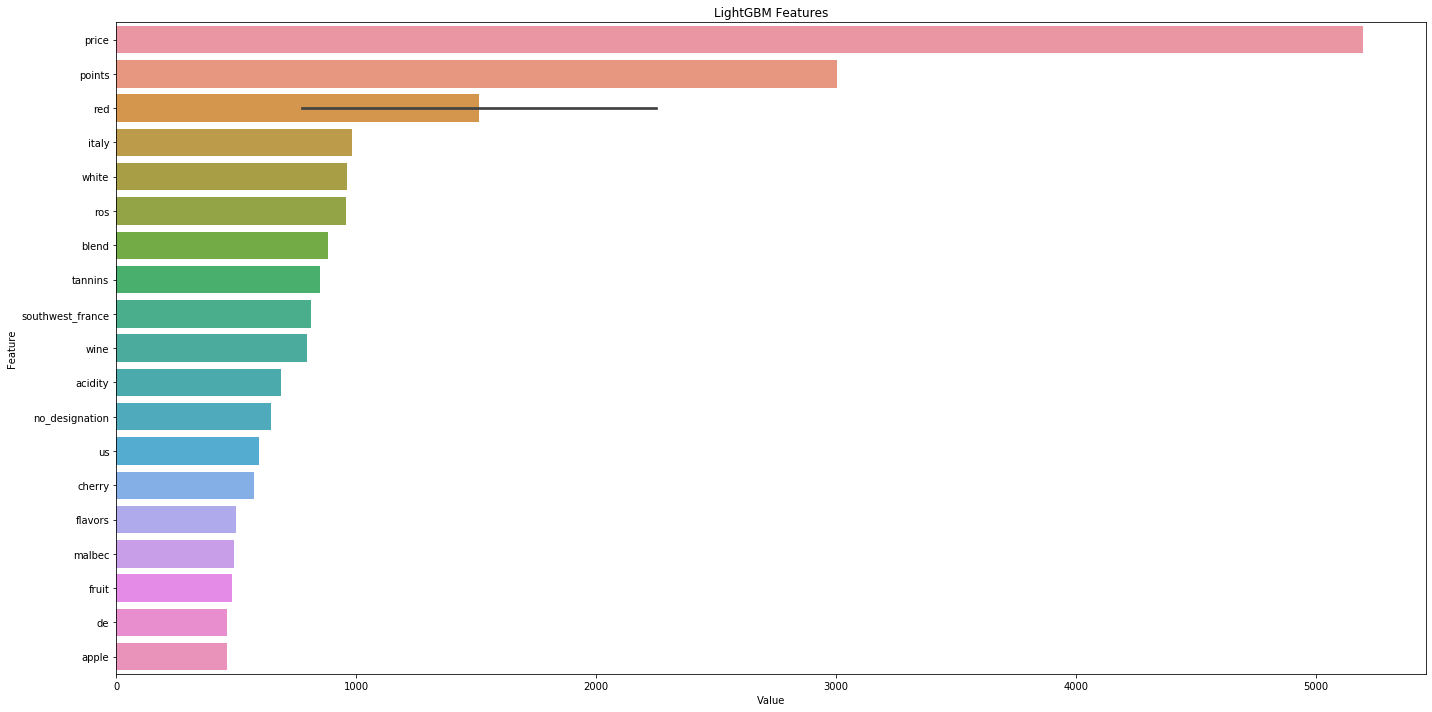

In [145]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp)#.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

<h3>Conclusion

By running the bow and tfidf datasets - maximum accuracy on TRAIN data - was found to be <b>97.79%</b> using the <b>LGBMClassifier</b> using the bow dataset.


<B>TO NOTE:</B>
Before sending the model to production few things have to be noted-
    1. There may be chances of Overfitting here, so the train data needs to be split into train and validation data and Overfitting/Underfitting has to be taken care by hyperparameter tuning. 
    2. Feature Engineering can be applied to improve accuracy.
    
<b>Feature Engineering: (to be checked)</b>
    1. No. of reviews per customer/user_name
    2. No.of reviews per - a.country 
                           b.designation
                           c. province
                           d. region_1
                           e. region_2
                           f. winery
    3. Alot range for - a. price
                        b. points

<h3>Summary

1. The data was looked over and attributes were studied.
2. NaN values were handled
3. Imputation was done for the missing price values where I imputed the missing values with the mean value of the dataset.
4. Data Preprocessing was done.
5. Categorical, Numerical and Text Data were encoded and stacked together in a horizontal stack.
6. Various models were trained on these hstack data